
# Binary Semantic Segmentation: Cloud detection with U-net and Hub ☁
Author: Margaux Masson-Forsythe

## Imports

In [ ]:
!pip3 install hub==2.0.4

In [ ]:
import hub
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage import img_as_ubyte
from glob import glob  
import tensorflow as tf
import random
import pandas as pd
from PIL import Image
import numpy as np
import os
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tqdm import tqdm

## Load Data from Hub

In [ ]:
print(tf.__version__)

2.5.0


In [ ]:
print(hub.__version__)

2.0.4


In [ ]:
# Load the data
print("Load data...")
ds = hub.dataset("hub://margauxmforsythe/38-cloud-segmentation") 

Load data...
Opening dataset in read-only mode as you don't have write permissions.
hub://margauxmforsythe/38-cloud-segmentation loaded successfully.


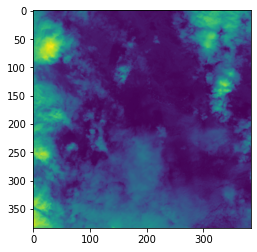

In [ ]:
for i in range(len(ds)):  
  plt.imshow(ds.images[i].numpy()[:, :, 0])
  plt.show()
  break

## Hub dataset to Tensorflow Dataset

In [ ]:
# we choose to only use 100 images for training because of GPU limit capacity in Google Colab
image_count = 100
ds_tf = ds[:image_count].tensorflow()

def to_model_fit(item):
  x = item['images']
  # Normalize
  x = x / tf.reduce_max(x)
  y = item['masks'] / 255
  return (x, y)

ds_tf = ds_tf.map(lambda x: to_model_fit(x))

(384, 384, 4)
(384, 384, 1)
[0. 1.]


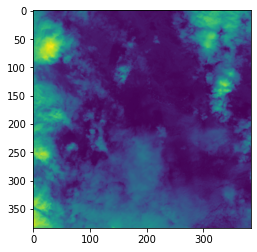

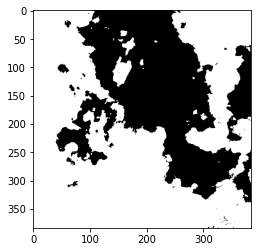

In [ ]:
for img, label in ds_tf:
  print(img.shape)
  print(label.shape)
  print(np.unique(label))
  plt.imshow(img[:,:,0])
  plt.show()
  plt.imshow(label[:,:,0], cmap="gray")
  plt.show()
  break

In [ ]:
train_size = int(0.8 * image_count)
val_size = int(0.1 * image_count)
test_size = int(0.1 * image_count)
batch_size = 6

ds_tf = ds_tf.shuffle(image_count)
test_ds = ds_tf.take(test_size)
train_ds = ds_tf.skip(test_size)
val_ds = train_ds.take(val_size)
train_ds = train_ds.skip(val_size)

print(f"{train_size} training images, {val_size} validation images and {test_size} test images. Batch size of {batch_size}")

train_ds = train_ds.shuffle(train_size)
train_ds = train_ds.batch(batch_size)

val_ds = val_ds.shuffle(val_size)
val_ds = val_ds.batch(batch_size)

test_ds = test_ds.batch(1)

80 training images, 10 validation images and 10 test images. Batch size of 6


## Model definition

In [ ]:
def unet(pretrained_weights=None, input_shape=(256, 256, 1), num_classes=12):
    inputs = Input(input_shape)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)

    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)

    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis=3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)

    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)
    
    model = Model(inputs=inputs, outputs=conv10)

    # model.summary()

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

## Training

In [ ]:
model = unet(input_shape = (384,384,4))

In [ ]:
if not os.path.isdir("./checkpoints"):
    print("Create folder checkpoints")
    os.mkdir("./checkpoints")

In [ ]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('./checkpoints/weights.epoch-{epoch:02d}-val-iou-{val_iou:.4f}.hdf5',
                                                 monitor='val_iou', 
                                                 mode='max', verbose=1,
                                                 save_best_only=True,
                                                 save_weights_only=True)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Recall(name="recall"), 
                       tf.keras.metrics.Precision(name="precision"), 
                       tf.keras.metrics.MeanIoU(num_classes=2, name='iou')]) 

In [ ]:
model.fit(train_ds, 
          validation_data=val_ds, 
          epochs = 20,
          callbacks = [checkpoint_callback])

Epoch 1/20
14/14 [==============================] - 66s 2s/step - loss: 0.8854 - accuracy: 0.5495 - recall: 0.6465 - precision: 0.5351 - iou: 0.2539 - val_loss: 0.6984 - val_accuracy: 0.5086 - val_recall: 0.9987 - val_precision: 0.4448 - val_iou: 0.3031

Epoch 00001: val_iou improved from -inf to 0.30307, saving model to ./checkpoints/weights.epoch-01-val-iou-0.3031.hdf5
Epoch 2/20
14/14 [==============================] - 15s 967ms/step - loss: 0.5596 - accuracy: 0.7303 - recall: 0.8923 - precision: 0.6615 - iou: 0.2610 - val_loss: 0.5270 - val_accuracy: 0.8104 - val_recall: 0.9036 - val_precision: 0.7428 - val_iou: 0.2684

Epoch 00002: val_iou did not improve from 0.30307
Epoch 3/20
14/14 [==============================] - 15s 983ms/step - loss: 0.5581 - accuracy: 0.7198 - recall: 0.7415 - precision: 0.7060 - iou: 0.2531 - val_loss: 0.5936 - val_accuracy: 0.6192 - val_recall: 1.0000 - val_precision: 0.5652 - val_iou: 0.2526

Epoch 00003: val_iou did not improve from 0.30307
Epoch 4/20

## Evaluation on test set

In [ ]:
path_to_best_weights = "./checkpoints/weights.epoch-13-val-iou-0.3982.hdf5"
model.load_weights(path_to_best_weights) # for loading a specific set of weights
model.evaluate(test_ds)

10/10 [==============================] - 5s 60ms/step - loss: 0.6227 - accuracy: 0.6042 - recall: 0.7637 - precision: 0.5364 - iou: 0.2792


[0.6226964592933655,
 0.6041693687438965,
 0.7636838555335999,
 0.5364013314247131,
 0.2791985273361206]

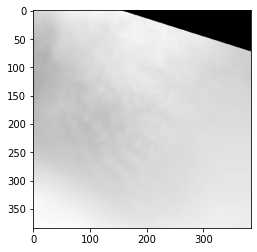

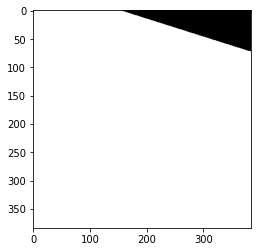

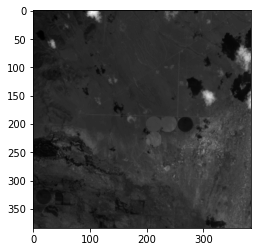

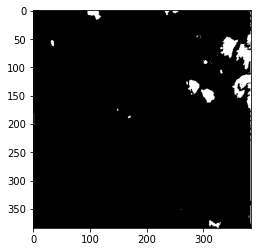

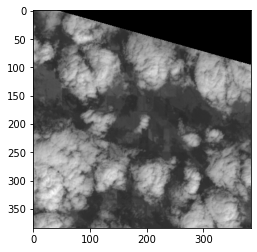

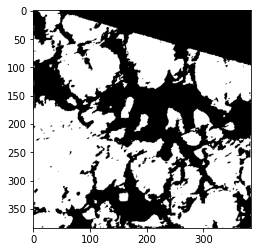

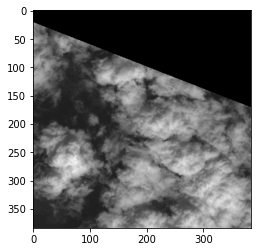

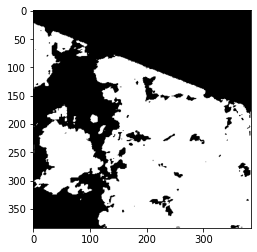

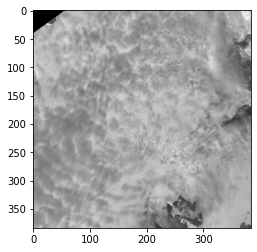

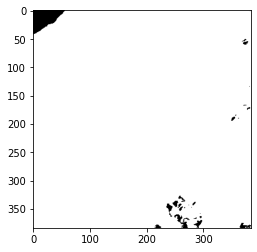

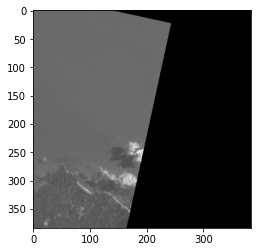

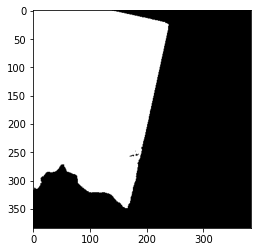

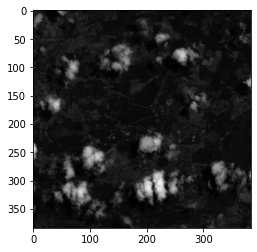

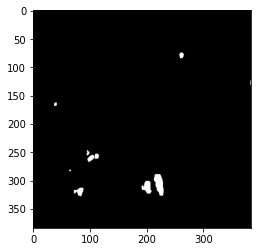

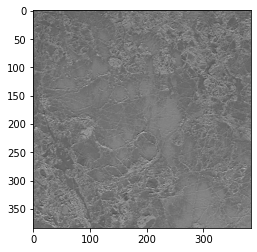

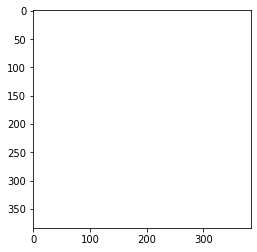

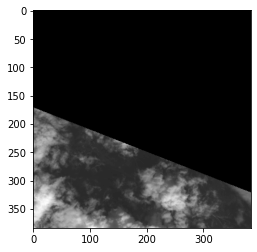

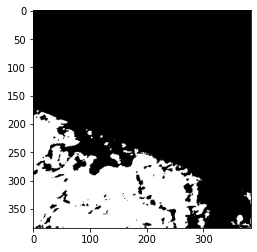

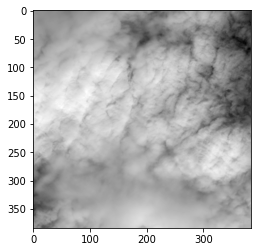

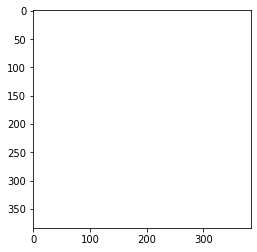

In [ ]:
i = 0
for img, label in test_ds:
  pred = (model.predict(img)[0] > 0.5).astype(np.uint8)
  plt.imshow(img[0][:,:,0], cmap="gray")
  plt.show()
  plt.imshow(pred[:,:,0], cmap="gray")
  plt.show()
  i = i + 1
  if i > 20:
    break

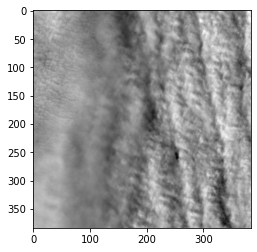

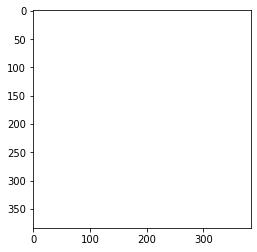

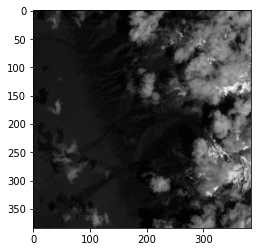

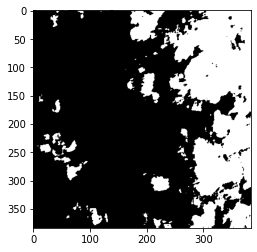

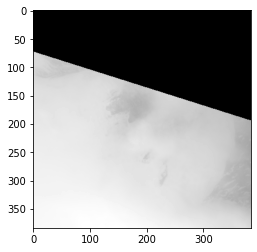

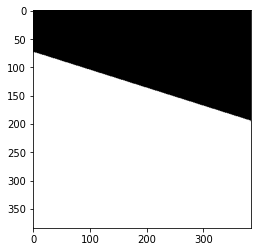

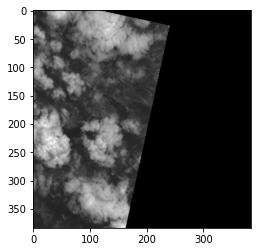

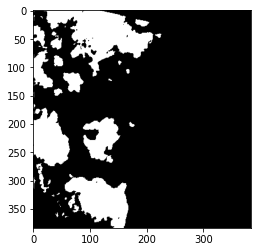

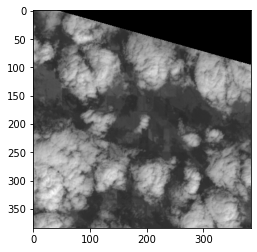

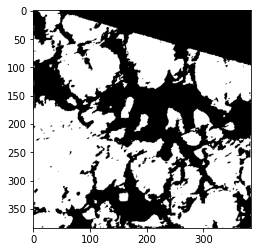

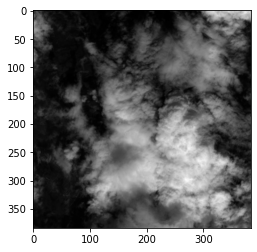

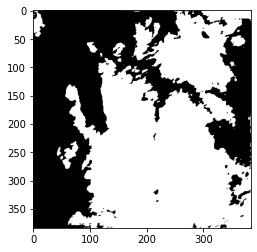

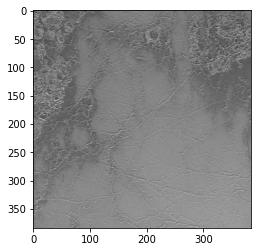

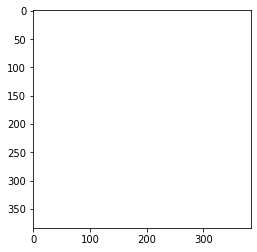

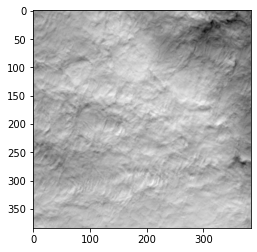

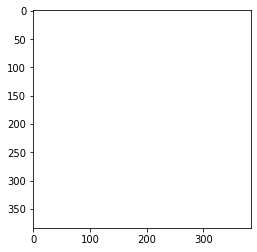

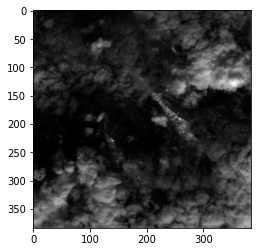

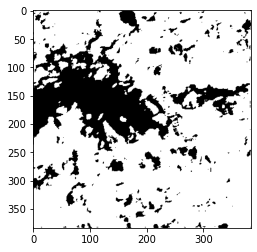

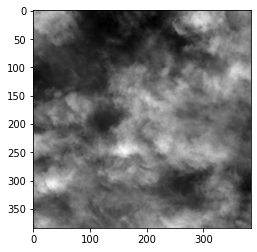

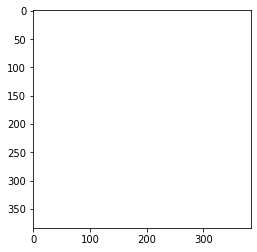

In [ ]:
i = 0
for img, label in test_ds:
  pred = (model.predict(img)[0] > 0.5).astype(np.uint8)
  plt.imshow(img[0][:,:,0], cmap="gray")
  plt.show()
  plt.imshow(pred[:,:,0], cmap="gray")
  plt.show()
  i = i + 1
  if i > 20:
    break

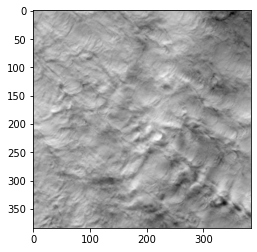

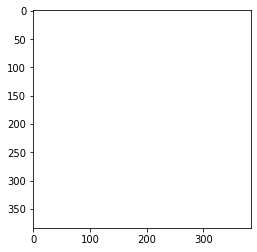

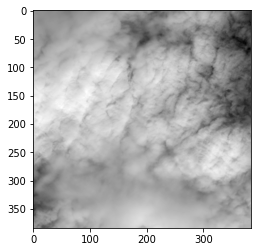

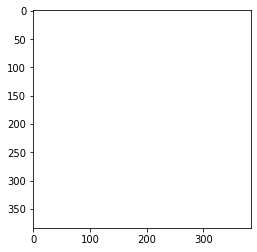

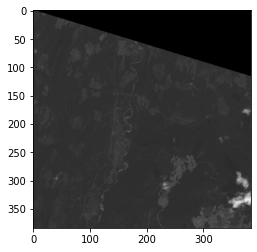

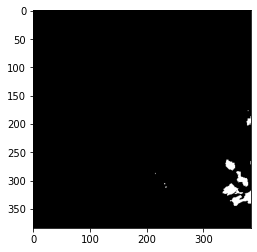

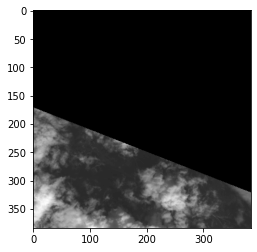

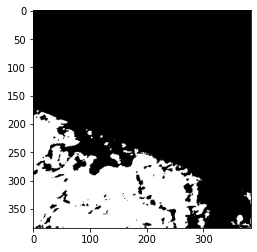

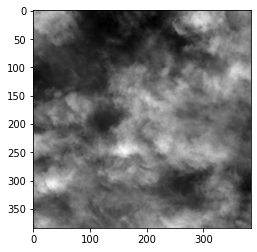

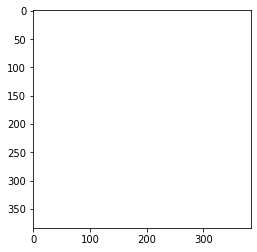

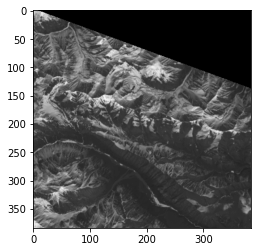

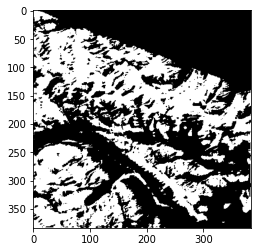

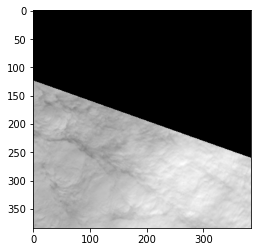

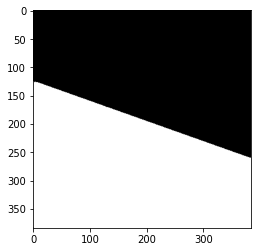

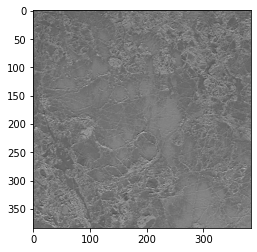

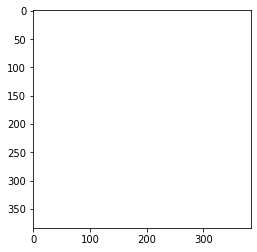

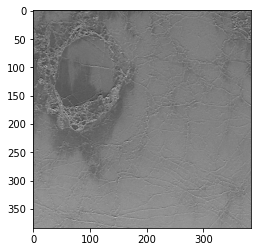

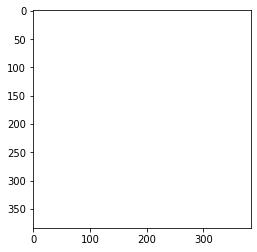

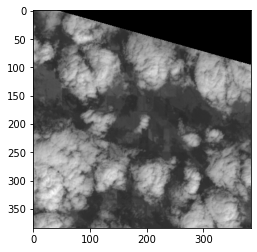

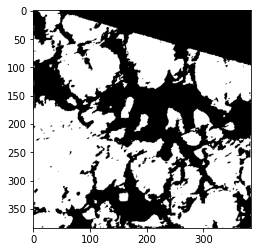

In [ ]:
i = 0
for img, label in test_ds:
  pred = (model.predict(img)[0] > 0.5).astype(np.uint8)
  plt.imshow(img[0][:,:,0], cmap="gray")
  plt.show()
  plt.imshow(pred[:,:,0], cmap="gray")
  plt.show()
  i = i + 1
  if i > 40:
    break